# Variable Elimination example
Problem taken from Maxwell Libbrecht's YouTube video on [34.1 - Variable elimination example](https://youtu.be/vL6k0Purj4k?si=MC19iebLh-QFOrfO).

Solution adapted from Alice Gao's Lecture on the [Variable Elimination Algorithm](https://cs.uwaterloo.ca/~a23gao/cs486686_f21/lecture_notes/Lecture_13_on_Variable_Elimination_Algorithm.pdf).

## Background

Probabilistic graphical models, such as Markov Random Fields (MRFs), Bayesian networks etc., are graphical methods to represent joint distribution over some set of random variables. We can then perform inference on the random variables using these representations. In this notebook, we will _not_ go into how these representations are constructed but discuss a way of performing inference over these models using the _Variable Elimination_ method.

Variable elimination is a technique used to perform _exact inference_ over probabilistic graphical models. "Exact" here means that instead of an approximate solution (_e.g._, through loopy belief propagation or sampling-based methods), an exact one can be found.

_Why variable elimination?_ In the context of inference, our goal is always to find the distribution of a particular random variable. The naive way to do this from a joint distribution is to marginalize out the other random variables as is, while variable elimination groups the factors with the same variables together before any marginalization. For instance, say we want to calculate the marginal distribution $P(A)$ from the joint distribution $P(A,B,C)$. We would simply integrate (or sum in the discrete case) over the support &mdash; range of possible values &mdash; of the other random variables: $P(A) = \int_B \int_C P(A,B,C) dC dB$. This becomes computationally expensive as we increase the number of random variables. **Variable elimination provides a substantial improvement over the brute force marginalization in terms of computational complexity.**

In brief, variable elimination consists of the following steps:
1. **Defining factors**: a factor is an abstract concept that can represent a joint or conditional probability; it is a function that maps random variables into some likelihood.
2. **Apply evidence**: based on the evidence (formally introduced later), we can assign the observed value(s) to the factors with corresponding variables.
4. **Collect Marginalize hidden variables**: based on our query (formally introduced later), we can marginalize out the hidden variables (that are not part of the query) out of the joint distribution.
3. **Multiply factors**: combine the remaining query variable factors through element-wise (variable-wise) multiplication.
5. **Normalize**: to obtain a proper probability distribution.

More details on each step can be found in [Alice Gao's lecture](https://cs.uwaterloo.ca/~a23gao/cs486686_f21/lecture_notes/Lecture_13_on_Variable_Elimination_Algorithm.pdf).

<!-- CSS styling -->
<style>
    .mermaid {
        display: flex !important;
        justify-content: center;
        align-items: center;
        text-align: center;
    }

    .centered-table {
        display: flex !important;
        justify-content: center;
    }
</style>

## Example

Consider the following problem where we have a sequence of events that culminates on _whether the grass on someone's lawn is wet_, as represented by a Bayesian network. Each node is a binary variable indicating whether the stated event has happened.

```mermaid
graph TD;
    n1(("cloudy? (C)")) --> n21(("rainy? (R)"));
    n1(("cloudy? (C)")) --> n22(("sprinklers? (S)"));
    n21(("rainy? (R)")) --> n3(("wet? (W)"));
    n22(("sprinklers? (S)")) --> n3(("wet? (W)"));
```

In brief, the network describes the conditional independence between the events within the joint distribution:
\begin{align*}
P(C,R,S,W) &= P(C) P(R \mid C) P(S \mid C) P(W \mid R, S).
\end{align*}

We also have a pre-determined model of these conditional variables, _i.e._, table of conditional probabilities. <!-- As we will see a bit later, these conditional probabilities are factors that we use in the Markov Random Field (MRF). -->

_How likely is it to be cloudy?_
<div class="centered-table">

| $C$ | False | True |
| --- | --- | --- |
| $P(C)$ | $1/2$ | $1/2$ | 

</div>

<br/>

_How likely is it to rain given that it is (or isn't) cloudy?_
<div class="centered-table">

| $R$ | False | True |
| --- | --- | --- |
| $P(R \mid C=\text{False})$ | $1$ | $0$ |
| $P(R \mid C=\text{True})$ | $1/2$ | $1/2$ |

</div>

<br/>

_How likely is it that the owner of the lawn turns on the sprinklers given that it is (or isn't) cloudy?_
<div class="centered-table">

| $S$ | False | True |
| --- | --- | --- |
| $P(S \mid C=\text{False})$ | $1/4$ | $3/4$ |
| $P(S \mid C=\text{True})$ | $3/4$ | $1/4$ |

</div>

<br/>

_How likely is it that the grass is wet given that it did (or didn't) rained and the sprinklers were on (or not)?_
<div class="centered-table">

| $W$ | False | True |
| --- | --- | --- |
| $P(W \mid R=\text{False}, S=\text{False})$ | $1$ | $0$ |
| $P(W \mid R=\text{True}, S=\text{False})$ | $0$ | $1$ |
| $P(W \mid R=\text{False}, S=\text{True})$ | $0$ | $1$ |
| $P(W \mid R=\text{True}, S=\text{True})$ | $0$ | $1$ |

</div>

Now, we can perform inference on the random variables. Specifically, we can answer the question: _what is the probability (distribution) that it is cloudy if we noticed the grass is wet: $P(C \mid W=\text{True})$?_ Formally, this is known as a _query_: $C$ is the query variable, $W=\text{True}$ is the evidence variable, and everything else are hidden variables.

## Solution Sketch
From the Bayesian network, we can decompose the joint distribution into separable (conditional) probabilities
\begin{align*}
    P(C,R,S,W) &= P(C) P(R \mid C) P(S \mid C) P(W \mid R, S).
\end{align*}

But we are only interested in $P(C \mid W=\text{True})$  (_i.e._, the query), which is a conditional probability. To relate the full joint distribution with our conditional probability, we find an expression that contains a joint probability over the variables of interest. In our case, we want to find an expression containing $P(C, W)$. Thus, we start with Bayes rule
\begin{align*}
    P(C \mid W=\text{True}) &= \frac{P(C, W=\text{True})}{P(W=\text{True})} \\
    &= \frac{P(C, W=\text{True})}{\sum_{c \in \{\text{False, True}\}} P(C=c, W=\text{True})}
\end{align*}
where the second line is made possible because $P(W=\text{True})$ is a marginal distribution of $P(C,W=\text{True})$.

Unfortunately, we don't have $P(C, W=\text{True})$, but we can apply the marginalization trick again; $P(C, W=\text{True})$ is a marginal distribution of $P(C,R,S,W=\text{True})$. Then, we can substitute the factors as needed
\begin{align*}
    P(C, W=\text{True}) &= \sum_{s, r} P(C,R,S,W=\text{True}) \\
    &= \sum_{s, r} P(C) P(R=r \mid C) P(S=s \mid C) P(W=\text{True} \mid R=r, S=s) \\
    &= P(C) \sum_{s} P(S=s \mid C) \sum_{r} P(R=r \mid C) P(W=\text{True} \mid R=r, S=s).
\end{align*}

If we define the initial (conditional) probabilities as the following factors
\begin{align*}
    P(C,R,S,W) &= P(C) P(R \mid C) P(S \mid C) P(W \mid R, S) \\
    &= f_1(C) f_2(C,R) f_3(C,S) f_4(R,S,W).
\end{align*}
our joint distribution now becomes
\begin{align*}
    P(C, W=\text{True}) &= P(C) \sum_{s} P(S=s \mid C) \sum_{r} P(R=r \mid C) P(W=\text{True} \mid R=r, S=s) \\
    &= f_1(C) \sum_{s} f_3(C, S=s) \sum_{r} f_2(C, R=r) f_4(R=r, S=s, W=\text{True}).
\end{align*}

Furthermore, we can apply the evidence to update the initial factors, then iteratively group the sums into new factors
\begin{align*}
    & & P(C, W=\text{True}) &= f_1(C) \sum_{s} f_3(C, S=s) \sum_{r} f_2(C, R=r) f_4(R=r, S=s, W=\text{True}) \\
    & \text{(Apply evidence)} & &= f_1(C) \sum_{s} f_3(C, S=s) \sum_{r} f_2(C, R=r) f_5(R=r, S=s) \\
    & \text{(Group $R$ terms)} & &= f_1(C) \sum_{s} f_3(C, S=s) \sum_{r} f_6(C, R=r, S=s) \\
    & \text{(Group $r$ sum)} & &= f_1(C) \sum_{s} f_3(C, S=s) f_7(C, S=s) \\
    & \text{(Group $S$ terms)} & &= f_1(C) \sum_{s} f_8(C, S=s) \\
    & \text{(Group $s$ sum)} & &= f_1(C) f_9(C) \\
    & \text{(Group $C$ terms)} & &= f_{10}(C).
\end{align*}

Finally, we can calculate $P(C \mid W=\text{True})$ as
\begin{align*}
    P(C \mid W=\text{True}) &= \frac{P(C, W=\text{True})}{\sum_{c \in \{\text{False, True}\}} P(C=c, W=\text{True})} \\
    &= \frac{f_{10}(C)}{\sum_{c \in \{\text{False, True}\}} f_{10}(C=c)} \\
    &\eqqcolon f_{11}(C).
\end{align*}

<!-- CSS styling -->
<style>
    .centered-table {
        display: flex !important;
        justify-content: center;
    }
</style>

## Detailed Solution
### Defining factors
We need to define a factor for every variable/node in the Bayesian network. Based on the given probability tables, we can define our factors as follows
\begin{align*}
    f_1(C) &\coloneqq P(C), \\
    f_2(C,S) &\coloneqq P(S \mid C), \\
    f_3(C,R) &\coloneqq P(R \mid C), \\
    f_4(R,S,W) &\coloneqq P(W \mid R, S).
\end{align*}

Hence, the joint distribution in terms of the factors is simply 
\begin{align*}
    P(C,R,S,W) &= P(C) P(R \mid C) P(S \mid C) P(W \mid R, S) \\
    &= f_1(C) f_2(C,R) f_3(C,S) f_4(R,S,W).
\end{align*}

### Apply evidence
The only factor that is affected by our evidence is $f_4(R,S,W)$. By applying the evidence, we convert $P(W \mid R, S)$ to $P(W = \text{True} \mid R, S) \eqqcolon f_5(R,S)$. The updated probability table for $f_5(R,S)$ is then:

<div class="centered-table">

| | $f_5(R,S)$ |
| --- | --- |
| $P(W=\text{True} \mid R=\text{False}, S=\text{False})$ | $0$ |
| $P(W=\text{True} \mid R=\text{True}, S=\text{False})$ | $1$ |
| $P(W=\text{True} \mid R=\text{False}, S=\text{True})$ | $1$ |
| $P(W=\text{True} \mid R=\text{True}, S=\text{True})$ | $1$ |

</div>

### Collect and Marginalize hidden variables
Since we only care about the query variable $C$, factors with the hidden variables $R, S$ will be marginalized out from the existing factors to give us new factors.

We start by marginalizing the hidden variable $R$, which involves grouping the factors together first before summing them
\begin{align*}
    f_6(C,R,S) &\coloneqq f_2(C,R) f_5(R,S) \\
    f_7(C,S) &\coloneqq \sum_{r \in \{\text{False, True}\}} f_6(C,R=r,S).
\end{align*}

The table for $f_7(C,S)$ can be obtained by first combining (element-wise multiplying) the tables for $f_2(C,R)$ and $f_5(R,S)$ to get $f_6(C,R,S)$ as described in the first line.
<div class="centered-table">

| $R$ | False | True |
| --- | --- | --- |
| $f_2 \cdot f_5 = P(R \mid C=\text{False}) \cdot P(W=\text{True} \mid R, S=\text{False})$ | $1 \cdot 0 = 0$ | $0 \cdot 1 = 0$ |
| $f_2 \cdot f_5 = P(R \mid C=\text{False}) \cdot P(W=\text{True} \mid R, S=\text{True})$ | $1 \cdot 1 = 1$ | $0 \cdot 1 = 0$ |
| $f_2 \cdot f_5 = P(R \mid C=\text{True}) \cdot P(W=\text{True} \mid R, S=\text{False})$ | $1/2 \cdot 0 = 0$ | $1/2 \cdot 1 = 1/2$ |
| $f_2 \cdot f_5 = P(R \mid C=\text{True}) \cdot P(W=\text{True} \mid R, S=\text{True})$ | $1/2 \cdot 1 = 1/2$ | $1/2 \cdot 1 = 1/2$ |

</div>

Then we marginalize over $R$ as described in the second line.
<div class="centered-table">

| | $f_7(C,S)$ |
| --- | --- |
| $f_6(C=\text{False}, R=\textbf{False}, S=\text{False}) + f_6(C=\text{False}, R=\textbf{True}, S=\text{False})$ | $0 + 0 = 0$ |
| $f_6(C=\text{False}, R=\textbf{False}, S=\text{True}) + f_6(C=\text{False}, R=\textbf{True}, S=\text{True})$ | $1 + 0 = 1$ |
| $f_6(C=\text{True}, R=\textbf{False}, S=\text{False}) + f_6(C=\text{True}, R=\textbf{True}, S=\text{False})$ | $0 + 1/2 = 1/2$ |
| $f_6(C=\text{True}, R=\textbf{False}, S=\text{True}) + f_6(C=\text{True}, R=\textbf{True}, S=\text{True})$ | $1/2 + 1/2 = 1$ |

</div>

We proceed to do the same with $S$, this time with the updated factor $f_7(C,S)$
\begin{align*}
    f_8(C,S) &\coloneqq f_3(C,S) f_7(C,S) \\
    f_9(C) &\coloneqq \sum_{s \in \{\text{False, True}\}} f_8(C,S=s).
\end{align*}

The first line gives us the following table for $f_8(C,S)$.
<div class="centered-table">

| $S$ | False | True |
| --- | --- | --- |
| $f_3 \cdot f_7 = P(S \mid C=\text{False}) \cdot f_7(C=\text{False}, S)$ | $1/4 \cdot 0 = 0$ | $3/4 \cdot 1 = 3/4$ |
| $f_3 \cdot f_7 = P(S \mid C=\text{True}) \cdot f_7(C=\text{True}, S)$ | $3/4 \cdot 1/2 = 3/8$ | $1/4 \cdot 1 = 1/4$ |

</div>

The second line thus gives us the marginalized table for $f_9(C)$.
<div class="centered-table">

| | $f_9(C)$ |
| --- | --- |
| $f_8(C=\text{False}, S=\textbf{False}) + f_8(C=\text{False}, S=\textbf{True})$ | $0 + 3/4 = 3/4$ |
| $f_8(C=\text{True}, S=\textbf{False}) + f_8(C=\text{True}, S=\textbf{True})$ | $3/8 + 1/4 = 5/8$ |

</div>

At the end of this step, each remaining factor should contain only the query variables. In our case, we are left with $f_1(C)$ and $f_9(C)$.

### Multiply the remaining factors
In this penultimate step, we simply multiply the remaining factors
\begin{align*}
    f_{10}(C) &\coloneqq f_1(C) f_9(C).
\end{align*}

The corresponding table for $f_{10}(C)$ is found as follows.
<div class="centered-table">

| $C$ | False | True |
| --- | --- | --- |
| $f_1 \cdot f_9 = P(C) \cdot f_9(C)$ | $1/2 \cdot 3/4 = 3/8$ | $1/2 \cdot 5/8 = 5/16$ |

</div>

### Normalize
Finally, to achieve our goal of calculating $P(C \mid W=\text{True})$, we normalize the final factor so that it becomes a proper probability distribution.
\begin{align*}
    f_{11}(C) &\coloneqq P(C \mid W=\text{True}) = \frac{f_{10}(C)}{\sum_{c \in \{\text{False, True}\}} f_{10}(C=c)}.
\end{align*}

After variable elimination, we find the probabilities for $P(C \mid W=\text{True})$ as shown in this table.
<div class="centered-table">

| | $P(C \mid W=\text{True})$ |
| --- | --- |
| $f_{10}(C=\text{False})/(f_{10}(C=\textbf{False}) + f_{10}(C=\textbf{True}))$ | $(3/8) / (3/8 + 5/16) = 6/11 $ |
| $f_{10}(C=\text{True})/(f_{10}(C=\textbf{False}) + f_{10}(C=\textbf{True}))$ | $(5/16) / (3/8 + 5/16) = 5/11 $ |

</div>

That is, _given that the grass is wet_, we can infer that _it is slightly more likely that it is cloudy_.

## Conversion of Bayesian network to a Markov Random Field (MRF)
_These notes are from [Maxwell Libbrecht's video](https://youtu.be/vL6k0Purj4k?si=MC19iebLh-QFOrfO) on using variable elimination on the MRF which I couldn't fully understand. Specifically, the reference to the clique factors $\psi$ was unclear in regards to the nodes/edges on the MRF._

The Bayesian network can be converted to a Markov Random Field, as shown below. The additional edge ($R$-$S$) is brought about by the _moralization_ process.

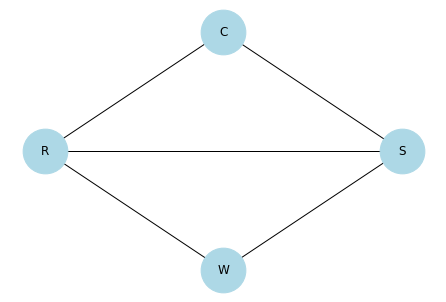

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Define node positions manually
positions = {"C": (0, 1), "R": (-1, 0), "S": (1, 0), "W": (0, -1)}

# Add nodes
G.add_nodes_from(positions)

# Add edges
edges = [("C", "R"), ("C", "S"), ("R", "S"), ("R", "W"), ("S", "W")]
G.add_edges_from(edges)

# Draw the graph
nx.draw(G, pos=positions, with_labels=True, node_size=2000, node_color="lightblue")
plt.axis("off")  # Turn off axis labels
plt.show()

Note that because $W$ is now observed &mdash; it's an evidence variable &mdash; we can remove the node from the representation. This is based on the concept of [_d-separation_](http://web.mit.edu/jmn/www/6.034/d-separation.pdf) which allows us to determine independent variables in the MRF; because $W$ is given, it is independent and removed from the graph. Thus, the new graph looks like the following.

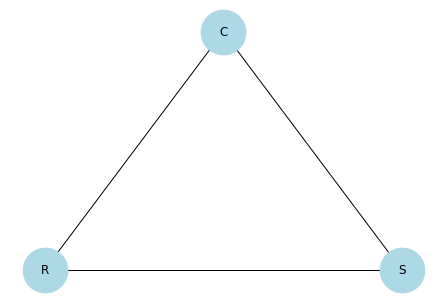

In [2]:
# Modify nodes and edges
try:
    G.remove_node("W") # remove evidence node
except:
    pass

# Draw the graph
nx.draw(G, pos=positions, with_labels=True, node_size=2000, node_color="lightblue")
plt.axis("off")  # Turn off axis labels
plt.show()